In [1]:
# Load the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import interpolation as inter
from PIL import Image as im
import pickle
import cv2
from tqdm import tqdm
from scipy.ndimage import rotate
import time
import joblib
from sklearn.metrics import accuracy_score,f1_score,classification_report
import os
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

In [2]:
labels = [ 'Scheherazade New' , 'Marhey' , 'Lemonada' , 'IBM Plex Sans Arabic']
image_size = 600
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show() 

In [3]:
# Load the images from fonts-dataset folder
def load_images():
    # Load the images from the fonts-dataset folder
    images_train = []
    labels_train = []
    # Use tqdm to show a progress bar
    for i in tqdm(labels):
        for filename in os.listdir(f'fonts-dataset/{i}'):
            img = cv2.imread(f'fonts-dataset/{i}/{filename}', cv2.IMREAD_GRAYSCALE)
            # img = cv2.resize(img, (image_size, image_size))
            images_train.append(img)
            labels_train.append(i)
    return images_train, labels_train



In [4]:
# Load the images
X_train, y_train = load_images()
# Change the y_train to numbers
y_train = [labels.index(i) for i in y_train]

100%|██████████| 4/4 [00:31<00:00,  7.88s/it]


In [5]:
def find_score(arr, angle):
    """
    Find the score of the skew angle to be used in deskewing the image
    
    Args:
    arr: the image array
    angle: the angle to rotate the image by
    
    Returns:
    hist: the histogram of the image
    score: the score of the skew angle
    """
    data = rotate(arr, angle, reshape=False, order=0)
    hist = np.sum(data, axis=1)
    score = np.sum((hist[1:] - hist[:-1]) ** 2)
    return hist, score

def deskew(binary_img):
    """
    Deskew the image
    
    Args:
    binary_img: the binary image
    
    Returns:
    pix: the deskewed image
    """
    bin_img = (binary_img // 255.0)
    # angles to check for skew angle = 45 degrees and 90 degrees and 180
    angles = np.array ([0 , 45 , 90 , 135 , 180 , 225 , 270 , 315])
    scores = []
    for angle in angles:
        hist, score = find_score(bin_img, angle)
        scores.append(score)

    best_score = max(scores)
    best_angle = angles[scores.index(best_score)]
    print('Best angle: {}'.format(best_angle))

    # correct skew
    data = rotate(bin_img, best_angle, reshape=False, order=0)
    img = im.fromarray((255 * data).astype("uint8"))

    pix = np.array(img)
    return pix , best_angle

def is_inverted(img):
    """
    Check if an image is inverted (rotated by 180 degrees)
    
    Args:
    img: the image array
    
    Returns:
    inverted: a boolean indicating if the image is inverted
    """
    top_half = img[:img.shape[0]//2]
    bottom_half = img[img.shape[0]//2:]
    
    return np.mean(top_half) > np.mean(bottom_half)

# def vexpand(gray_img, color:int):
#     """Expand the image by some space vertically in both directions"""

#     color = 1 if color > 0 else 0
#     (h, w) = gray_img.shape[:2]
#     space = np.ones((10, w)) * 255 * color

#     return np.block([[space], [gray_img], [space]])


# def hexpand(gray_img, color:int):
#     """Expand the image by some space horizontally in both directions"""

#     color = 1 if color > 0 else 0
#     (h, w) = gray_img.shape[:2]
#     space = np.ones((h, 10)) * 255 * color

#     return np.block([space, gray_img, space])

# def valid(row, col, vis, word):
#     return (row < vis.shape[0] and col < vis.shape[1] and row >= 0 and col >=0 and vis[row][col] == 0 and word[row][col] > 0)

# def dfs(row, col, vis, word):

#     dX = [0,0,1,1,-1,-1,1,-1]
#     dY = [1,-1,0,1,0,-1,-1,1]
#     vis[row][col] += 1
#     for i in range(8):
#         if(valid(row+dX[i],col+dY[i],vis, word)):
#             dfs(row+dX[i], col+dY[i], vis, word)
#     return

In [29]:
def replace_black_corners(img, angle, threshold= 5 ):
  """
  Replace black corner pixels with white based on the deskewed image and angle.

  Args:
      img: The deskewed binary image.
      angle: The angle of rotation applied during deskewing.
      threshold: The threshold angle to consider a corner (default: 20 degrees).

  Returns:
      The image with white corners.
  """
  rows, cols = img.shape

#   # Define corner regions based on the image size and threshold angle
#   top_left_corner = np.where((img[:threshold , :threshold] == 0) & (angle > threshold))
#   top_right_corner = np.where((img[:threshold, -cols+threshold:] == 0) & (angle < -threshold))
#   bottom_left_corner = np.where((img[-rows+threshold:, :threshold] == 0) & (angle < -threshold))
#   bottom_right_corner = np.where((img[-rows+threshold +5 :, -cols+threshold +5 :] == 0) & (angle > threshold))

#   # Replace corner pixels with white
#   img[top_left_corner[0], top_left_corner[1]] = 255
#   img[top_right_corner[0], top_right_corner[1]] = 255
#   img[bottom_left_corner[0], bottom_left_corner[1]] = 255
#   img[bottom_right_corner[0], bottom_right_corner[1]] = 255

  return img

def preprocess(img):
    """
    Preprocess the image
    
    Args:
    img: the image
    
    Returns:
    img: the preprocessed image
    """
    sharpen_kernel = np.array([[0,-1, 0], [-1,5,-1], [0,-1,0]])
    img = cv2.medianBlur(img, 3) # To remove Salt and Pepper noise
    img = cv2.filter2D(img, -1, sharpen_kernel)  # Sharpen the image
    img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1] # Convert the image to binary
    deskewed_img, angle = deskew(img) # Deskew the image
    # if (angle != 0):
    #     # Find contours in the image
    #     contours, _ = cv2.findContours(deskewed_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #     # Fill in the outermost contour fill to the end of the image
    #     cv2.drawContours(deskewed_img, contours, -1, 255, -1)
    if (angle != 0):
        deskewed_img = replace_black_corners(deskewed_img, angle)
        
    final_img = cv2.bitwise_not(deskewed_img) if np.mean(deskewed_img) > 127 else deskewed_img # Invert the image if the mean is less than 127 
    return final_img

In [80]:
# # Preprocess the images
# X_train_preprocess = [preprocess(i) for i in tqdm(X_train)]
    
# # Dump the preprocessed images to a file
# with open('preprocessed_images.pkl', 'wb') as f:
#     pickle.dump(X_train_preprocess, f)

In [7]:
# Load the preprocessed images
with open('preprocessed_images.pkl', 'rb') as f:
    X_train_preprocess = pickle.load(f)

In [8]:
import numpy as np
import cv2 as cv


def save_image(img, folder, title):
    cv.imwrite(f'./{folder}/{title}.png', img)

def projection(gray_img, axis:str='horizontal'):
    """ Compute the horizontal or the vertical projection of a gray image """

    if axis == 'horizontal':
        projection_bins = np.sum(gray_img, 1).astype('int32')
    elif axis == 'vertical':
        projection_bins = np.sum(gray_img, 0).astype('int32')

    return projection_bins

Best angle: 45


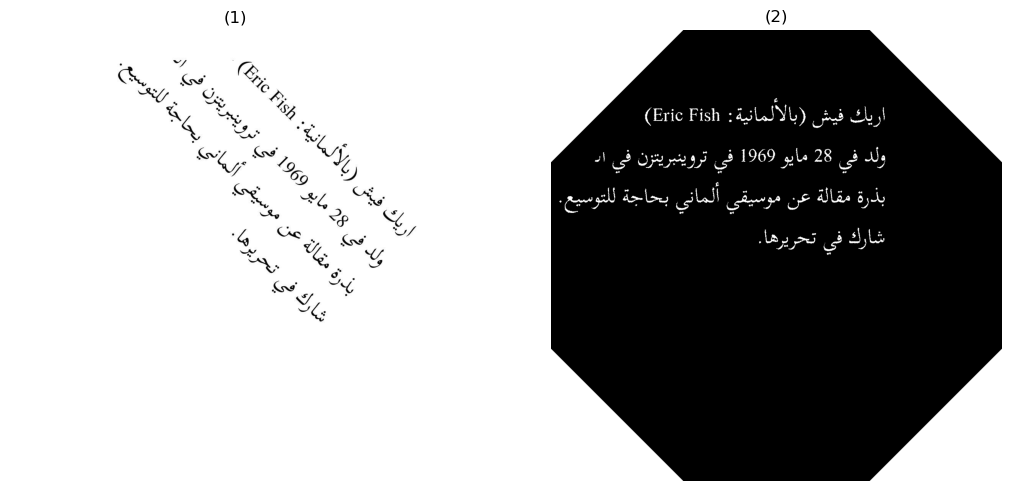

In [30]:
# def preprocess(image):

#     # Maybe we end up using only gray level image.
#     # gray_img = cv.bitwise_not(image) # Invert the image
#     binary_img = cv.threshold(image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]
#     deskewed_img = deskew(binary_img)
#     return deskewed_img


def projection_segmentation(clean_img, axis, cut=15, min_width=20, min_height=30):
    """Segment the image based on the projection profile

    Args:
        clean_img : Preprocessed image
        axis (str): 'horizontal' or 'vertical'
        cut (int, optional): Gap between the segments. Defaults to 3.
        min_width (int, optional): Width of the segment. Defaults to 5.
        min_height (int, optional): Height of the segment. Defaults to 5.

    Returns:
        _type_: _description_
    """
    segments = []
    start = -1
    cnt = 0

    projection_bins = projection(clean_img, axis)
    for idx, projection_bin in enumerate(projection_bins):

        if projection_bin != 0:
            cnt = 0
        if projection_bin != 0 and start == -1:
            start = idx
        if projection_bin == 0 and start != -1:
            cnt += 1
            if cnt >= cut:
                if axis == 'horizontal':
                    # Line segmentation
                    segment = clean_img[max(start-1, 0):idx, :]
                    if segment.shape[0] >= min_height:                    
                        segments.append(segment)
                elif axis == 'vertical':
                    # Word segmentation
                    segment = clean_img[:, max(start-1, 0):idx]
                    if segment.shape[1] >= min_width:
                        segments.append(segment)
                cnt = 0
                start = -1
    
    return segments


# Line Segmentation
#----------------------------------------------------------------------------------------
def line_horizontal_projection(image, cut=3):

    # Segmentation    
    lines = projection_segmentation(image, axis='horizontal', cut=cut)
    return lines


# Word Segmentation
#----------------------------------------------------------------------------------------
def word_vertical_projection(line_image, cut=3):
    
    line_words = projection_segmentation(line_image, axis='vertical', cut=cut)
    line_words.reverse()
    return line_words


def extract_words(img, visual=0):

    lines = line_horizontal_projection(img)
    words = []
    
    for idx, line in enumerate(lines):
        
        if visual:
            # Check for the size of the line to be greater than 30
            # if line.shape[0] > 30:
            save_image(line, 'lines', f'line{idx}')

        line_words = word_vertical_projection(line)
        for w in line_words:
            # if len(words) == 585:
            #     print(idx)
            words.append((w, line))
        # words.extend(line_words)

    # breakpoint()
    if visual:
        for idx, word in enumerate(words):
            # check for the size of the word to be greater than 30
            # print (word[0].shape)
            # if word[0].shape[0] < 100 and word[0].shape[1] > 20 :
            save_image(word[0], 'words', f'word{idx}')
    return words

# # Try to extract the words from the preprocessed images
p = preprocess(X_train[564])

# show_images([X_train[999],p])

# Extract the words from the preprocessed images
words = extract_words(p, visual=1)
show_images([X_train[564], p])



In [10]:
# Resize the images to 600x600
X_train_resized = []
for i in tqdm(X_train_preprocess):
    img = cv2.resize(i, (image_size, image_size))
    X_train_resized.append(img)
X_train_resized = np.array(X_train_resized)
    

100%|██████████| 4000/4000 [00:02<00:00, 1703.58it/s]


In [11]:
# Apply hog for the images
from skimage.feature import hog

X_train_hog = []
for i in tqdm(X_train_resized):
    X_train_hog.append(hog(i, orientations= 8, pixels_per_cell=(32, 32), cells_per_block=(4, 4), block_norm='L2-Hys'))
    
# Print the shape of the hog features
print(X_train_hog[0].shape)

# # Try hog on one image
# hog_image = hog(X_train[0], orientations= 8, pixels_per_cell=(32, 32), cells_per_block=(4,4), block_norm='L2-Hys')
# print(hog_image.shape)

100%|██████████| 4000/4000 [02:29<00:00, 26.75it/s]

(28800,)


In [12]:
# Split the data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_hog, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [13]:
# Make a pipeline for the model which consist of StandardScaler , PCA and the model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Create a pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.99)),
])

# Fit the pipeline
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.99))])

In [14]:
# Transform the data
X_train_transformed = pipe.transform(X_train)
X_test_transformed = pipe.transform(X_test)

# Print the shape of the transformed data
print(X_train_transformed.shape)

(3200, 1804)


In [20]:
# Initialize the model and fit the data

# Initialize the model
# {'warm_start': True, 'solver': 'saga', 'penalty': 'l2', 'C': 0.001}
model = LogisticRegression(warm_start=True, solver='saga', penalty='l2', C=0.01,random_state=42)
# model = LogisticRegression()

# Fit the model
model.fit(X_train_transformed, y_train)

# Predict the test data
y_pred = model.predict(X_test_transformed)

# Predict the train data
y_pred_train = model.predict(X_train_transformed)

# Print the training accuracy
print(f"Training Accuracy: {accuracy_score(y_train, y_pred_train)}")

# Print the testing accuracy
print(f"Testing Accuracy: {accuracy_score(y_test, y_pred)}")

# Print the f1 score of the training data
print(f"Training F1 Score: {f1_score(y_train, y_pred_train, average='weighted')}")

# Print the f1 score of the testing data
print (f"Testing F1 Score: {f1_score(y_test, y_pred, average='weighted')}")

# Print the classification report of the training data
print(classification_report(y_train, y_pred_train))

# Print the classification report of the testing data
print(classification_report(y_test, y_pred))

# Save the model
joblib.dump(model, 'logistic_model.pkl')

Training Accuracy: 0.980625
Testing Accuracy: 0.92625
Training F1 Score: 0.9806383431192538
Testing F1 Score: 0.9258806463487401
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       800
           1       0.98      0.98      0.98       800
           2       1.00      1.00      1.00       800
           3       0.98      0.97      0.98       800

    accuracy                           0.98      3200
   macro avg       0.98      0.98      0.98      3200
weighted avg       0.98      0.98      0.98      3200

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       200
           1       0.90      0.94      0.92       200
           2       0.99      1.00      0.99       200
           3       0.94      0.85      0.89       200

    accuracy                           0.93       800
   macro avg       0.93      0.93      0.93       800
weighted avg       0.93      0.93      0.93       800



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


['logistic_model.pkl']

In [21]:
# Initialize the SVM model
svm = SVC(C=1 , kernel='rbf', gamma='scale', probability=True, random_state=42)

# Fit the SVM on the training data
svm.fit(X_train_transformed, y_train)

# Predict the labels of the test set
y_pred = svm.predict(X_test_transformed)
# Predict the labels of the training set
y_pred_train = svm.predict(X_train_transformed)

# Print the accuracy of the SVM model on the training set
print(f"Accuracy of SVM model on the training set: {accuracy_score(y_train, y_pred_train)*100}")

# Print the accuracy of the SVM model on the test set
print(f"Accuracy of SVM model: {accuracy_score(y_test, y_pred)*100}")

# Print the classification report of the SVM model
print(classification_report(y_train, y_pred_train, target_names=labels))

# Print the classification report of the SVM model
print(classification_report(y_test, y_pred, target_names=labels))

# Save the SVM model as h5 file
joblib.dump(svm, 'svm_model.pkl')

Accuracy of SVM model on the training set: 96.125
Accuracy of SVM model: 90.125
                      precision    recall  f1-score   support

    Scheherazade New       0.93      0.94      0.94       800
              Marhey       0.95      0.96      0.95       800
            Lemonada       1.00      1.00      1.00       800
IBM Plex Sans Arabic       0.97      0.94      0.95       800

            accuracy                           0.96      3200
           macro avg       0.96      0.96      0.96      3200
        weighted avg       0.96      0.96      0.96      3200

                      precision    recall  f1-score   support

    Scheherazade New       0.82      0.89      0.86       200
              Marhey       0.93      0.87      0.90       200
            Lemonada       0.99      0.99      0.99       200
IBM Plex Sans Arabic       0.88      0.85      0.86       200

            accuracy                           0.90       800
           macro avg       0.90      0.90      

['svm_model.pkl']

In [24]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
# Initialize the Random Forest Classifier
# Initialize the Random Forest Classifier
random_forest_clf = RandomForestClassifier(random_state=42)

# Define the hyperparameters distribution (use same ranges as before)
param_dist = {
    'n_estimators': np.arange(2, 500), 
    'min_samples_split':  range(2,51),                    # 2 to 50
    'min_samples_leaf': range(1,21),                      # 1 to 20
    'max_depth': range(5, 51, 5),                              # 5 to 50 with step of 5
    'min_impurity_decrease': np.linspace(0.0, 0.2, 20),                   # Decide a reasonable range here (with 20 values)
    'max_depth': range(5, 51, 5)                          # 5 to 50 with step of 5
}

# Initialize RandomizedSearchCV
clf_searched = RandomizedSearchCV(random_forest_clf, param_dist, n_iter=100, cv=5, random_state=42, n_jobs=-1, verbose=1)

clf_searched.fit(X_train_transformed, y_train)
relevant_columns = ['param_n_estimators', 'param_min_samples_split', 'param_min_samples_leaf', 'param_max_depth', 'param_min_impurity_decrease', 
                    'mean_test_score', 'std_test_score', 'rank_test_score']
cv_results_df = pd.DataFrame(clf_searched.cv_results_)[relevant_columns].round(decimals=3).sort_values(by='rank_test_score')
cv_results_df.head(10)

# Best parameters of the Random Forest Classifier
# {'n_estimators': 371, 'min_samples_split': 48, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.0, 'max_depth': 5}

Fitting 5 folds for each of 100 candidates, totalling 500 fits


,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_min_impurity_decrease,mean_test_score,std_test_score,rank_test_score
42,371,48,4,30,0.0,0.776,0.014,1
46,453,11,11,40,0.0,0.766,0.014,2
82,421,17,8,35,0.0,0.765,0.021,3
65,428,8,12,5,0.0,0.752,0.007,4
89,200,41,3,40,0.0,0.738,0.011,5
43,480,28,8,15,0.010526,0.622,0.009,6
12,405,48,1,50,0.010526,0.620,0.011,7
13,309,4,4,50,0.010526,0.617,0.011,8
56,320,41,7,40,0.010526,0.616,0.012,9
37,380,2,9,35,0.010526,0.613,0.012,10


In [25]:
svm = SVC()

param_dist = {
    'C': np.logspace(-3, 3, 100), 
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
    'gamma': ['scale', 'auto']
}

clf_searched = RandomizedSearchCV(svm, param_dist, n_iter=100, cv=5, random_state=42, n_jobs=-1, verbose=1)

clf_searched.fit(X_train_transformed, y_train)
relevant_columns = ['param_C', 'param_kernel', 'param_gamma', 'mean_test_score', 'std_test_score', 'rank_test_score']
cv_results_df = pd.DataFrame(clf_searched.cv_results_)[relevant_columns].round(decimals=3).sort_values(by='rank_test_score')
cv_results_df.head(10)

# Best parameters of the SVM
# {C : 20.09233 , kernel : 'rbf', gamma : 'scale' , score : 0.908}

Fitting 5 folds for each of 100 candidates, totalling 500 fits


,param_C,param_kernel,param_gamma,mean_test_score,std_test_score,rank_test_score
29,20.09233,rbf,scale,0.908,0.008,1
18,40.370173,rbf,scale,0.907,0.009,2
20,93.260335,rbf,scale,0.907,0.009,2
78,30.538555,rbf,scale,0.907,0.009,2
28,432.876128,rbf,scale,0.907,0.009,2
97,497.702356,rbf,scale,0.907,0.009,2
86,869.749003,rbf,scale,0.907,0.009,2
32,23.101297,rbf,scale,0.907,0.009,2
52,107.226722,rbf,scale,0.907,0.009,2
7,4.977024,rbf,scale,0.906,0.011,10
